In [1]:
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import pandas as pd
import utilities
from calitp import *
from shared_utils import geography_utils
from shared_utils import utils 

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [23]:
# Original map
tmobile = dg.read_parquet("Tmobile.parquet")

FileNotFoundError: /home/jovyan/data-analyses/cell_coverage/Tmobile.parquet

In [3]:
# tmobile_gdf = tmobile.compute()

In [4]:
# tmobile_gdf.plot()

## Verizon 
* Crashes when clipping to Kern County
* Doesn't work at all with districts shapefile

In [5]:
# Original map
verizon = dg.read_parquet("Verizon.parquet")
verizon_gdf = verizon.compute()

<AxesSubplot:>

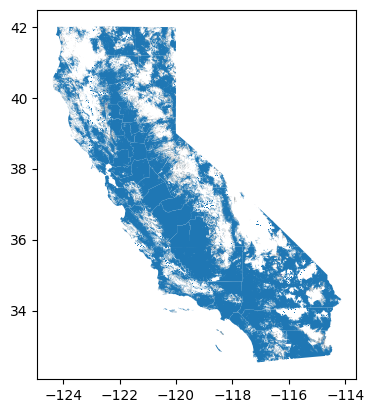

In [6]:
verizon_gdf.plot()

In [7]:
# Original map
# t = dg.read_parquet("ATT.parquet")

In [8]:
# verizon_test_one_district = utilities.find_difference_and_clip(verizon, d4) 

In [9]:
counties = utilities.get_counties()

In [10]:
sf = counties.loc[counties.county_name == "San Francisco"].reset_index(drop = True)

In [11]:
verizon_test_one_county = utilities.find_difference_and_clip(verizon, sf) 

<AxesSubplot:>

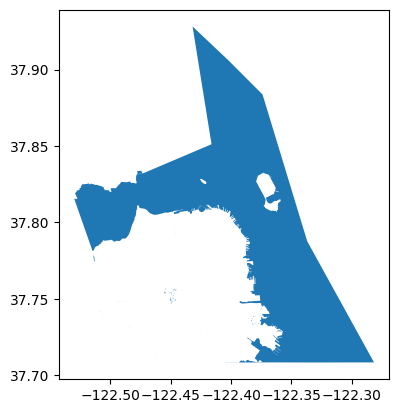

In [12]:
verizon_test_one_county.plot()

In [13]:
kern = counties.loc[counties.county_name == "Kern"].reset_index(drop = True)

In [16]:
kern.geometry.is_valid.all()

True

In [17]:
import shapely.wkt

In [20]:
# Non node intersection line string 
# https://github.com/geopandas/geopandas/issues/1724
kern["geometry"] = kern["geometry"].apply(lambda x: shapely.wkt.loads(shapely.wkt.dumps(x, rounding_precision=4)))

<AxesSubplot:>

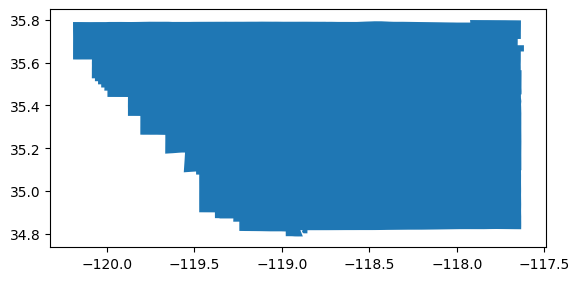

In [19]:
kern.plot()

In [21]:
verizon_test_one_county = utilities.find_difference_and_clip(verizon, kern) 

/opt/conda/lib/python3.10/site-packages/geopandas/tools/overlay.py:299: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


<AxesSubplot:>

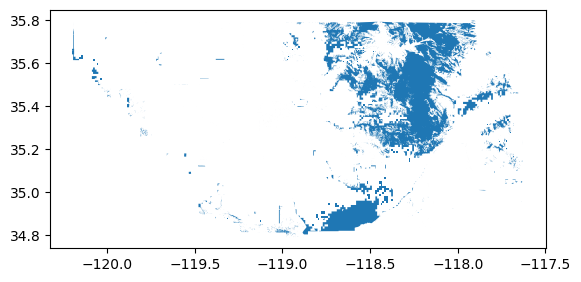

In [22]:
verizon_test_one_county.plot()

In [ ]:
county_names = counties.county_name.sort_values().unique().tolist()

In [ ]:
def breakout_counties(provider, gcs_file_path:str, file_name:str, counties_wanted:list):
    counties = utilities.get_counties()
    
    # Empty dataframe to hold each district after clipping
    full_gdf = pd.DataFrame()

    for i in counties_wanted:
        county_gdf = counties[counties.county_name==i].reset_index(drop = True)
        
        county_gdf_clipped = utilities.find_difference_and_clip(verizon, county_gdf) 
        full_gdf = dd.multi.concat([full_gdf, county_gdf_clipped], axis=0)
        print(f'done concating for {i}')
    
    # Turn this into a GDF
    full_gdf = full_gdf.compute()
    
    # Save to GCS
    utils.geoparquet_gcs_export(full_gdf, gcs_file_path, file_name) 
    print('saved to GCS')
    
    return full_gdf

In [ ]:
# verizon_function = breakout_counties(verizon, utilities.GCS_FILE_PATH,'verizon_madera_yuba',county_names2)

## Concat all separated out areas

In [ ]:
d1_4 = dg.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/att_clipped_d1_to_4.parquet"
)

In [ ]:
d5_8 = dg.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/att_clipped_d5_df8.parquet"
)

In [ ]:
d9_12 = dg.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/att_clipped_d9_df12.parquet"
)

In [ ]:
att_all = [d1_4, d5_8, d9_12]

In [ ]:
counties1 = dg.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/verizon_alpine_fresno.parquet"
)

In [ ]:
counties2 = dg.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/verizon_glenn_madera.parquet"
)

In [ ]:
counties3 = dg.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/verizon_madera_yuba.parquet"
)

In [ ]:
verizon_all = [counties1,counties2,counties3]

In [ ]:
# California is separated out into different gdfs that contain 
# portions of districts/counties. Concat them all together 
# to get the entirety of California again.
def concat_all_areas(all_gdf:list, gcs_file_path: str, file_name:str):
    
    # Empty dataframe
    full_gdf = pd.DataFrame()
    
    # Concat all the districts that were broken out into one
    full_gdf = dd.multi.concat(all_gdf, axis=0)
    
    # Turn it into a gdf
    full_gdf = full_gdf.compute()
    
    # Export
    utils.geoparquet_gcs_export(full_gdf, gcs_file_path,file_name)

    print('Saved to GCS')
    return full_gdf 

In [ ]:
verizon = concat_all_areas(verizon_all, utilities.GCS_FILE_PATH, "verizon_all_counties_except_Kern")

In [ ]:
verizon = dg.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/verizon_all_counties_except_Kern.parquet"
)

In [ ]:
verizon.compute().plot()